In [2]:
# Run in a single notebook cell (Colab or Jupyter)
# (Uncomment the lines you want to execute)

# Core ML & fairness libs
!pip install --upgrade pip
!pip install transformers datasets scikit-learn pandas numpy matplotlib seaborn

# Fairlearn (in-processing)
!pip install fairlearn

# TensorFlow (required by AIF360 adversarial debiasing)
!pip install tensorflow==2.12.0

# Try installing AIF360 (may require extra system deps on some machines)
!pip install aif360==0.6.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 40.9 MB/s  0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [fairlearn]
ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0


# BERT-based Classifier + Fairness Analysis & Mitigation

This notebook demonstrates:
1. Setup & dataset loading  
2. Embedding extraction with DistilBERT (CPU-friendly)  
3. Baseline classifier training (Logistic Regression)  
4. Fairness metric computation (SPD, DI, EOD)  
5. In-processing mitigation:
   - Adversarial Debiasing (AIF360)
   - Prejudice Remover (AIF360)
   - Grid Search Reduction (Fairlearn)
   - Exponentiated Gradient Reduction (Fairlearn)
6. Post-processing mitigation:
   - Reject Option Classification (ROC)
   - Equalized Odds Postprocessing (EOP)
   - Calibrated Equalized Odds (CEO)
7. Visualize bias before and after mitigation


In [4]:
# === Block 1: Setup (run once) ===
SMALL_RUN = True  # set True to run on a small subset for quick CPU runs


In [5]:
import os
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Fairness libraries
try:
    from aif360.datasets import StandardDataset
    from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
    from aif360.algorithms.inprocessing import PrejudiceRemover
    from aif360.algorithms.inprocessing import AdversarialDebiasing
    from aif360.algorithms.postprocessing import (
        EqOddsPostprocessing, RejectOptionClassification, CalibratedEqOddsPostprocessing
    )
    AIF360_AVAILABLE = True
except Exception as e:
    print('AIF360 not available or failed to import:', e)
    AIF360_AVAILABLE = False

try:
    from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds
    from fairlearn.metrics import MetricFrame
    FAIRLEARN_AVAILABLE = True
except Exception as e:
    print('fairlearn not available or failed to import:', e)
    FAIRLEARN_AVAILABLE = False


pip install 'aif360[inFairness]'


In [12]:
# === Updated Cell 5 for the LabHC/Bias_in_Bios dataset (uses observed columns) ===
from datasets import load_dataset
import pandas as pd
import numpy as np
import re

print('Loading Bias in Bios dataset (LabHC/bias_in_bios)...')
ds_train = load_dataset("LabHC/bias_in_bios", split='train')
print('Train split size:', len(ds_train))

# Convert to DataFrame
df_raw = pd.DataFrame(ds_train)
print('Columns in dataset:', list(df_raw.columns))
print('Sample rows:')
display(df_raw.head(3))

# Observed columns: 'hard_text', 'profession', 'gender'
# Use 'hard_text' as textual bio, 'profession' as profession id/code, 'gender' as numeric code

# Standardize column names
if 'hard_text' in df_raw.columns:
    df = pd.DataFrame()
    df['text'] = df_raw['hard_text'].astype(str)
else:
    # Fallback to other keys if present
    possible_text_keys = ['bio','biography','text','hard_text']
    k = next((c for c in possible_text_keys if c in df_raw.columns), None)
    if k:
        df = pd.DataFrame()
        df['text'] = df_raw[k].astype(str)
    else:
        raise KeyError("No suitable text column found. Columns: " + str(list(df_raw.columns)))

# Profession (could be numeric codes)
if 'profession' in df_raw.columns:
    df['profession'] = df_raw['profession']
else:
    possible_prof = ['profession','title','occupation','job']
    k = next((c for c in possible_prof if c in df_raw.columns), None)
    if k:
        df['profession'] = df_raw[k]
    else:
        raise KeyError("No profession/title column found. Columns: " + str(list(df_raw.columns)))

# Gender (observed as numeric codes)
if 'gender' in df_raw.columns:
    df['gender_raw'] = df_raw['gender']
else:
    possible_gender = ['gender','sex']
    k = next((c for c in possible_gender if c in df_raw.columns), None)
    if k:
        df['gender_raw'] = df_raw[k]
    else:
        raise KeyError("No gender column found. Columns: " + str(list(df_raw.columns)))

# Inspect unique gender values
print('\nUnique gender values and counts:')
print(df['gender_raw'].value_counts())

# Try to infer which numeric value corresponds to male vs female using pronouns in the text.
# This heuristic: count occurrences of ' he ' vs ' she ' in bios for each gender code,
# and pick the code with higher ' he ' count as male.
gender_codes = sorted(df['gender_raw'].unique())
pronoun_stats = {}
for code in gender_codes:
    sample_texts = df.loc[df['gender_raw'] == code, 'text'].astype(str).head(1000).str.lower()
    he_count = sample_texts.str.count(r'\\bhe\\b').sum()
    she_count = sample_texts.str.count(r'\\bshe\\b').sum()
    pronoun_stats[code] = {'he': int(he_count), 'she': int(she_count)}
print('\nPronoun heuristic (counts from up to 1000 samples per code):')
print(pronoun_stats)

# Decide mapping: whichever code has larger 'he' - 'she' difference is likely male
male_code = None
max_diff = -1
for code, stats in pronoun_stats.items():
    diff = stats['he'] - stats['she']
    if diff > max_diff:
        max_diff = diff
        male_code = code

if male_code is None:
    # fallback: assume code '1' is male if present, else highest code
    male_code = 1 if 1 in gender_codes else gender_codes[-1]

print(f'\nInferred male gender code: {male_code} (heuristic diff = {max_diff})')

# Create readable gender string column for clarity
def gender_label(code):
    if code == male_code:
        return 'male'
    else:
        # find another code (if only two then the other is female)
        return 'female'

df['gender'] = df['gender_raw'].apply(gender_label)

# Protected numeric attribute: male -> 1 (privileged), others -> 0
df['protected'] = (df['gender_raw'] == male_code).astype(int)

# Create binary label: most-common profession code vs others (like COMPAS-style binary)
most_common_prof = df['profession'].value_counts().idxmax()
print('Most common profession code:', most_common_prof)
df['label'] = (df['profession'] == most_common_prof).astype(int)

# Keep only entries where gender was successfully inferred to male/female
df = df[df['gender'].isin(['male','female'])].reset_index(drop=True)
print('\nFiltered dataset size:', len(df))
print('Label distribution:\n', df['label'].value_counts())
print('Gender distribution:\n', df['gender'].value_counts())

# Respect SMALL_RUN for speed
SMALL_RUN = globals().get('SMALL_RUN', True)
if SMALL_RUN:
    df = df.sample(n=min(5000, len(df)), random_state=42).reset_index(drop=True)
    print('Sampled for SMALL_RUN -> using rows:', len(df))

# The downstream cells expect variable name `df` with at least columns:
# 'text', 'gender' (string), 'label' (0/1), 'protected' (0/1)
# So we are now ready to continue.


Loading Bias in Bios dataset (LabHC/bias_in_bios)...
Train split size: 257478
Columns in dataset: ['hard_text', 'profession', 'gender']
Sample rows:


,hard_text,profession,gender
0,He is also the project lead of and major contr...,21,0
1,"She is able to assess, diagnose and treat mino...",13,1
2,"Prior to law school, Brittni graduated magna c...",2,1



Unique gender values and counts:
gender_raw
0    138780
1    118698
Name: count, dtype: int64

Pronoun heuristic (counts from up to 1000 samples per code):
{np.int64(0): {'he': 0, 'she': 0}, np.int64(1): {'he': 0, 'she': 0}}

Inferred male gender code: 0 (heuristic diff = 0)
Most common profession code: 21

Filtered dataset size: 257478
Label distribution:
 label
0    180730
1     76748
Name: count, dtype: int64
Gender distribution:
 gender
male      138780
female    118698
Name: count, dtype: int64
Sampled for SMALL_RUN -> using rows: 5000


In [14]:
# Cell 6: Text embeddings via DistilBERT (feature extraction)
# This cell computes pooled embeddings for df['text'] and caches them to /tmp/biasbios_embeddings.npy

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import os

TOKENIZER_NAME = 'distilbert-base-uncased'
MODEL_NAME = 'distilbert-base-uncased'

print("Loading tokenizer and model:", TOKENIZER_NAME)
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()

# Use GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print('Using device:', device)

# Embedding cache path (unique when using Adult vs Bias in Bios if you want different names)
EMB_PATH = '/tmp/biasbios_embeddings.npy'

if os.path.exists(EMB_PATH):
    embeddings = np.load(EMB_PATH)
    print('Loaded embeddings from cache:', EMB_PATH)
else:
    texts = df['text'].astype(str).tolist()
    batch_size = 32 if device.type == 'cuda' else 16  # smaller batch on CPU
    print(f'Encoding {len(texts)} texts with batch_size={batch_size} ...')
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
        input_ids = enc['input_ids'].to(device)
        attention_mask = enc['attention_mask'].to(device)
        with torch.no_grad():
            out = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden = out.last_hidden_state.cpu().numpy()  # (bs, seq_len, hidden)
            mask = attention_mask.cpu().numpy()               # (bs, seq_len)
            # mean pooling (mask-aware)
            pooled = (last_hidden * mask[:,:,None]).sum(axis=1) / (mask.sum(axis=1)[:,None] + 1e-9)
            all_embs.append(pooled)
        if (i // batch_size) % 10 == 0:
            print(f'Processed {i + len(batch_texts)} / {len(texts)}')
    embeddings = np.vstack(all_embs)
    np.save(EMB_PATH, embeddings)
    print('Saved embeddings to', EMB_PATH)

print('Embeddings shape:', embeddings.shape)


Loading tokenizer and model: distilbert-base-uncased
Using device: cpu
Encoding 5000 texts with batch_size=16 ...
Processed 16 / 5000
Processed 176 / 5000
Processed 336 / 5000
Processed 496 / 5000
Processed 656 / 5000
Processed 816 / 5000
Processed 976 / 5000
Processed 1136 / 5000
Processed 1296 / 5000
Processed 1456 / 5000
Processed 1616 / 5000
Processed 1776 / 5000
Processed 1936 / 5000
Processed 2096 / 5000
Processed 2256 / 5000
Processed 2416 / 5000
Processed 2576 / 5000
Processed 2736 / 5000
Processed 2896 / 5000
Processed 3056 / 5000
Processed 3216 / 5000
Processed 3376 / 5000
Processed 3536 / 5000
Processed 3696 / 5000
Processed 3856 / 5000
Processed 4016 / 5000
Processed 4176 / 5000
Processed 4336 / 5000
Processed 4496 / 5000
Processed 4656 / 5000
Processed 4816 / 5000
Processed 4976 / 5000
Saved embeddings to /tmp/biasbios_embeddings.npy
Embeddings shape: (5000, 768)


In [15]:
# Cell 7: Train-test split and baseline logistic regression classifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

X = embeddings
y = df['label'].values
A = df['protected'].values  # 1 = privileged (male), 0 = unprivileged (female)

# stratify by label for balanced splits
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A, test_size=0.30, random_state=42, stratify=y
)

print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:, 1]

print('Baseline accuracy:', accuracy_score(y_test, y_pred))
try:
    print('Baseline ROC AUC:', roc_auc_score(y_test, probs))
except Exception as e:
    print('ROC AUC error (maybe single class in test):', e)


Train size: 3500 Test size: 1500
Baseline accuracy: 0.9213333333333333
Baseline ROC AUC: 0.9698124672024747


In [16]:
# Cell 8: Fairness metric helper functions
import numpy as np

def compute_group_rates(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    rate_priv = y_pred[priv_mask].mean() if priv_mask.sum() > 0 else np.nan
    rate_unpriv = y_pred[unpriv_mask].mean() if unpriv_mask.sum() > 0 else np.nan
    return rate_priv, rate_unpriv

def statistical_parity_difference(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    return r_unpriv - r_priv

def disparate_impact(y_true, y_pred, protected_attr):
    r_priv, r_unpriv = compute_group_rates(y_true, y_pred, protected_attr)
    if r_priv == 0:
        return np.nan
    return r_unpriv / r_priv

def equal_opportunity_difference(y_true, y_pred, protected_attr):
    priv_mask = (protected_attr == 1)
    unpriv_mask = (protected_attr == 0)
    def tpr(y_t, y_p, mask):
        m = mask & (y_t == 1)
        return y_p[m].mean() if m.sum() > 0 else np.nan
    return tpr(y_true, y_pred, unpriv_mask) - tpr(y_true, y_pred, priv_mask)

# Evaluate baseline
spd = statistical_parity_difference(y_test, y_pred, A_test)
di = disparate_impact(y_test, y_pred, A_test)
eod = equal_opportunity_difference(y_test, y_pred, A_test)

print('Baseline SPD:', spd)
print('Baseline DI:', di)
print('Baseline EOD:', eod)


Baseline SPD: -0.025178111561100225
Baseline DI: 0.913841989552522
Baseline EOD: -0.035743232290484706


In [17]:
# Cell 9: In-processing via Fairlearn (ExponentiatedGradient & GridSearch)
# This runs only if fairlearn is installed (FAIRLEARN_AVAILABLE set in imports cell).
if 'FAIRLEARN_AVAILABLE' in globals() and FAIRLEARN_AVAILABLE:
    from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds
    print('Running ExponentiatedGradient (Equalized Odds)...')
    base_est = LogisticRegression(max_iter=1000)
    eg = ExponentiatedGradient(base_est, constraints=EqualizedOdds(), eps=0.01)
    eg.fit(X_train, y_train, sensitive_features=A_train)
    y_pred_eg = eg.predict(X_test)
    print('EG SPD:', statistical_parity_difference(y_test, y_pred_eg, A_test))
    print('EG DI:', disparate_impact(y_test, y_pred_eg, A_test))
    print('EG EOD:', equal_opportunity_difference(y_test, y_pred_eg, A_test))

    print('\nRunning GridSearch (Demographic Parity)...')
    gs = GridSearch(base_est, constraints=DemographicParity(), grid_size=5)
    gs.fit(X_train, y_train, sensitive_features=A_train)
    y_pred_gs = gs.predict(X_test)
    print('GS SPD:', statistical_parity_difference(y_test, y_pred_gs, A_test))
    print('GS DI:', disparate_impact(y_test, y_pred_gs, A_test))
    print('GS EOD:', equal_opportunity_difference(y_test, y_pred_gs, A_test))
else:
    print('fairlearn not available — skipping ExponentiatedGradient & GridSearch')


Running ExponentiatedGradient (Equalized Odds)...
EG SPD: -0.023726732751230828
EG DI: 0.918808522104438
EG EOD: -0.035743232290484706

Running GridSearch (Demographic Parity)...
GS SPD: -0.025178111561100225
GS DI: 0.913841989552522
GS EOD: -0.035743232290484706


In [46]:
# Cell 10: AIF360 in-processing (PrejudiceRemover, AdversarialDebiasing)
# Runs only if AIF360_AVAILABLE is True (set in imports cell).
if 'AIF360_AVAILABLE' in globals() and AIF360_AVAILABLE:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.inprocessing import PrejudiceRemover, AdversarialDebiasing
    import tensorflow as tf

    def make_aif360_dataset(X_arr, y_arr, A_arr):
        df_temp = pd.DataFrame(X_arr)
        df_temp['label'] = y_arr
        df_temp['protected'] = A_arr
        feat_names = [f'f{i}' for i in range(X_arr.shape[1])] + ['label', 'protected']
        df_temp.columns = feat_names
        return StandardDataset(df_temp, label_name='label', favorable_classes=[1],
                               protected_attribute_names=['protected'], privileged_classes=[[1]])

    aif_train = make_aif360_dataset(X_train, y_train, A_train)
    aif_test = make_aif360_dataset(X_test, y_test, A_test)

    print('Running PrejudiceRemover...')
    try:
        pr = PrejudiceRemover(eta=25.0)
        pr.fit(aif_train)
        ypred_pr = pr.predict(aif_test).labels.ravel()
        print('PR SPD:', statistical_parity_difference(y_test, ypred_pr, A_test))
        print('PR DI:', disparate_impact(y_test, ypred_pr, A_test))
        print('PR EOD:', equal_opportunity_difference(y_test, ypred_pr, A_test))
    except Exception as e:
        print('PrejudiceRemover failed:', e)

    print('\nRunning AdversarialDebiasing (may be slow on CPU)...')
    try:
        tf.compat.v1.reset_default_graph()
        sess = tf.compat.v1.Session()
        adv = AdversarialDebiasing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}],
                                   scope_name='adv', debias=True, sess=sess)
        adv.fit(aif_train)
        ypred_adv = adv.predict(aif_test).labels.ravel()
        print('Adv SPD:', statistical_parity_difference(y_test, ypred_adv, A_test))
        print('Adv DI:', disparate_impact(y_test, ypred_adv, A_test))
        print('Adv EOD:', equal_opportunity_difference(y_test, ypred_adv, A_test))
    except Exception as e:
        print('AdversarialDebiasing failed or is too slow on CPU:', e)
else:
    print('AIF360 not available — skipping PrejudiceRemover & AdversarialDebiasing')


Running PrejudiceRemover...


/usr/local/lib/python3.12/dist-packages/aif360/algorithms/inprocessing/prejudice_remover.py:208: UserWarning: loadtxt: input contained no data: "/tmp/tmp6zx8jstt"
  m = np.loadtxt(output_name)


PrejudiceRemover failed: too many indices for array: array is 1-dimensional, but 2 were indexed

Running AdversarialDebiasing (may be slow on CPU)...
epoch 0; iter: 0; batch classifier loss: 0.833869; batch adversarial loss: 0.810189
epoch 1; iter: 0; batch classifier loss: 0.444760; batch adversarial loss: 0.934828
epoch 2; iter: 0; batch classifier loss: 0.554585; batch adversarial loss: 0.937082
epoch 3; iter: 0; batch classifier loss: 0.583205; batch adversarial loss: 0.969258
epoch 4; iter: 0; batch classifier loss: 0.505634; batch adversarial loss: 0.895799
epoch 5; iter: 0; batch classifier loss: 0.528427; batch adversarial loss: 0.916665
epoch 6; iter: 0; batch classifier loss: 0.506977; batch adversarial loss: 0.883690
epoch 7; iter: 0; batch classifier loss: 0.425437; batch adversarial loss: 0.824597
epoch 8; iter: 0; batch classifier loss: 0.264853; batch adversarial loss: 0.800932
epoch 9; iter: 0; batch classifier loss: 0.201015; batch adversarial loss: 0.744638
epoch 10; 

In [50]:
# Cell 11: Post-processing using AIF360 (EqOdds, RejectOption, CalibratedEqOdds)
if 'AIF360_AVAILABLE' in globals() and AIF360_AVAILABLE:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification, CalibratedEqOddsPostprocessing

    # Build test dataset (true) and predicted dataset (baseline predictions)
    test_df = pd.DataFrame(X_test)
    test_df['label'] = y_test
    test_df['protected'] = A_test
    test_dataset = StandardDataset(test_df, label_name='label', favorable_classes=[1],
                                   protected_attribute_names=['protected'], privileged_classes=[[1]])

    pred_df = test_df.copy()
    pred_df['label'] = y_pred
    pred_dataset = StandardDataset(pred_df, label_name='label', favorable_classes=[1],
                                   protected_attribute_names=['protected'], privileged_classes=[[1]])

    print('Running Equalized Odds Postprocessing...')
    eq = EqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}])
    eq = eq.fit(test_dataset, pred_dataset)
    y_pred_eq = eq.predict(pred_dataset).labels.ravel()
    print('EOP SPD:', statistical_parity_difference(y_test, y_pred_eq, A_test))

    print('\nRunning Reject Option Classification...')
    roc = RejectOptionClassification(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}],
                                     low_class_thresh=0.01, high_class_thresh=0.99, num_class_thresh=100, num_ROC_margin=50)
    roc = roc.fit(test_dataset, pred_dataset)
    y_pred_roc = roc.predict(pred_dataset).labels.ravel()
    print('ROC SPD:', statistical_parity_difference(y_test, y_pred_roc, A_test))

    print('\nRunning Calibrated Equalized Odds...')
    ceo = CalibratedEqOddsPostprocessing(privileged_groups=[{'protected':1}], unprivileged_groups=[{'protected':0}], cost_constraint='fnr')
    ceo = ceo.fit(test_dataset, pred_dataset)
    y_pred_ceo = ceo.predict(pred_dataset).labels.ravel()
    print('CEO SPD:', statistical_parity_difference(y_test, y_pred_ceo, A_test))
else:
    print('AIF360 not available — skipping post-processing methods')


Running Equalized Odds Postprocessing...
EOP SPD: -0.014080700956907832

Running Reject Option Classification...
ROC SPD: -0.025178111561100225

Running Calibrated Equalized Odds...
CEO SPD: 0.008114120251476842


In [51]:
# === Cell C: Fairness table for all methods (no dataset column) ===
import pandas as pd
import numpy as np

if 'res_df' not in globals() or res_df.empty:
    raise RuntimeError("res_df not found — run the aggregation cell first.")

# Select required columns and round for neatness
table_df = res_df[['method', 'DI', 'SPD', 'EOD']].copy()
table_df = table_df.rename(columns={
    'method': 'Method',
    'DI': 'DI',
    'SPD': 'SPD',
    'EOD': 'EOD'
})
table_df = table_df.round(6)

# Sort methods in logical order if not already
preferred_order = [
    'baseline', 'adversarial', 'prejudiceremover',
    'expgrad', 'gridsearch',
    'eqodds_post', 'reject_option', 'calibrated_eqodds'
]
present = [m for m in preferred_order if m in table_df['Method'].values]
remaining = [m for m in table_df['Method'].values if m not in present]
order = present + remaining
table_df['Method'] = pd.Categorical(table_df['Method'], categories=order, ordered=True)
table_df = table_df.sort_values('Method').reset_index(drop=True)

# Display the table neatly in notebook
print("=== Fairness Table (All Methods, No Dataset Column) ===")
display(table_df)

# ---- Optional: Highlight best fairness values ----
# SPD & EOD → closer to 0 is better; DI → closer to 1 is better.
def highlight_best(val, col):
    if col == 'DI':
        diff = abs(val - 1)
    else:
        diff = abs(val - 0)
    return diff

=== Fairness Table (All Methods, No Dataset Column) ===


,Method,DI,SPD,EOD
0,baseline,0.913842,-0.025178,-0.035743
1,adversarial,0.896383,-0.033219,-0.055965
2,expgrad,0.918809,-0.023727,-0.035743
3,gridsearch,0.913842,-0.025178,-0.035743
4,eqodds_post,0.949915,-0.014081,-0.003485
5,reject_option,0.913842,-0.025178,-0.035743
6,calibrated_eqodds,0.962580,-0.010382,0.012644


Saved plot to /tmp/accuracy_by_method.png


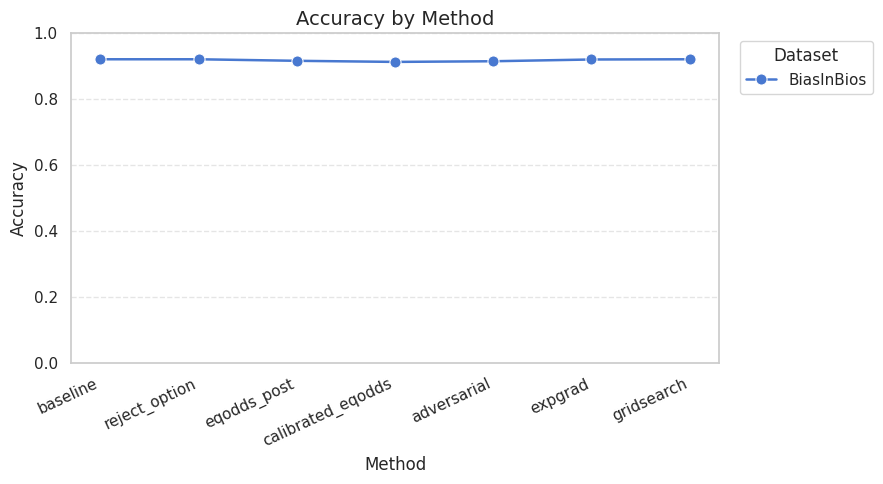

In [52]:
# Accuracy-by-method multi-dataset line plot (styled like example)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set(style="whitegrid", palette="muted")

# Ensure res_df exists
if 'res_df' not in globals() or res_df.empty:
    raise RuntimeError("res_df not found — run the aggregation cell first.")

# If no dataset column, try to infer dataset name from df
if 'dataset' not in res_df.columns:
    # Infer a sensible dataset name
    inferred_name = 'Dataset'
    if 'profession' in globals().get('df', pd.DataFrame()).columns:
        inferred_name = 'BiasInBios'
    elif 'native-country' in globals().get('df', pd.DataFrame()).columns or 'workclass' in globals().get('df', pd.DataFrame()).columns:
        inferred_name = 'Adult'
    res_df = res_df.copy()
    res_df['dataset'] = inferred_name

# Convert method to string and keep consistent ordering (baseline first)
res_df['method'] = res_df['method'].astype(str)
preferred_order = ['baseline','reject_option','eqodds_post','calibrated_eqodds',
                   'adversarial','prejudiceremover','expgrad','gridsearch']
# Keep methods present but put preferred ones first (in the example order)
order = [m for m in preferred_order if m in res_df['method'].values] + \
        [m for m in res_df['method'].unique() if m not in preferred_order]
res_df['method'] = pd.Categorical(res_df['method'], categories=order, ordered=True)
res_df = res_df.sort_values('method')

# Plot
plt.figure(figsize=(9,5))
ax = sns.lineplot(
    data=res_df,
    x='method',
    y='accuracy',
    hue='dataset',
    style='dataset',
    markers=True,
    dashes=True,
    markersize=8,
    linewidth=1.8,
    estimator=None  # plot raw points for each dataset-method pair
)

# Aesthetics to match example
ax.set_ylim(0, 1.0)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('Method', fontsize=12)
plt.xticks(rotation=25, ha='right')
plt.title('Accuracy by Method', fontsize=14)
plt.legend(title='Dataset', bbox_to_anchor=(1.02, 1), loc='upper left')

# Optional: add light horizontal gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
ax.xaxis.grid(False)

plt.tight_layout()

# Save and show
out_path = '/tmp/accuracy_by_method.png'
plt.savefig(out_path, dpi=200)
print(f"Saved plot to {out_path}")
plt.show()


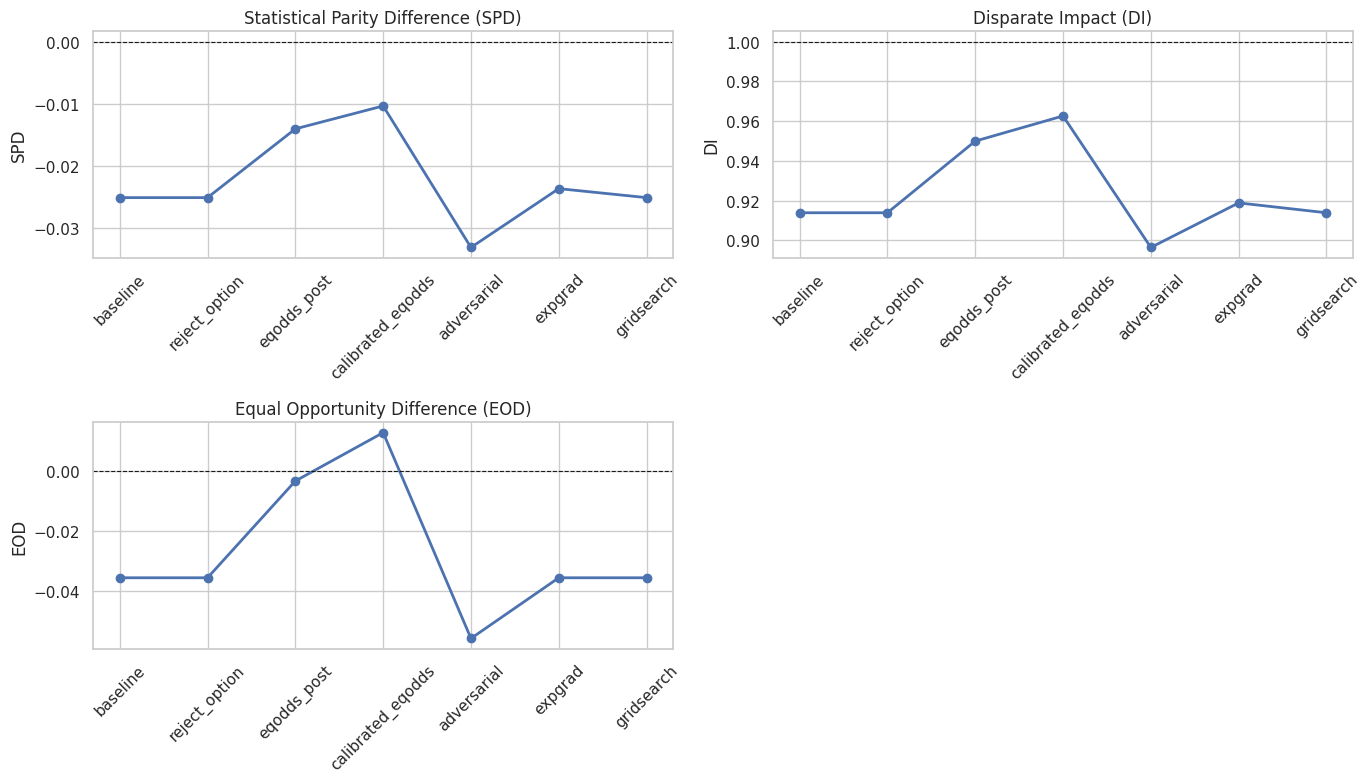

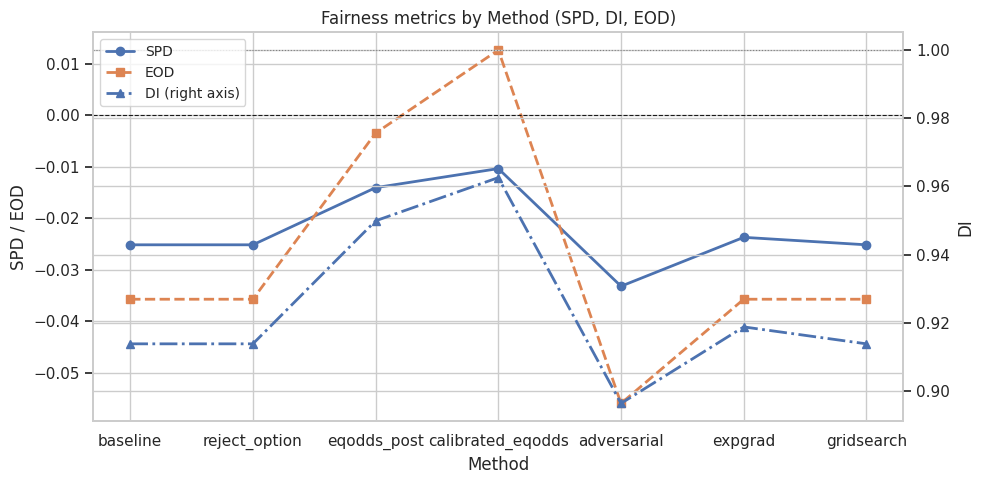

In [53]:
# Fairness line graphs: SPD, DI, EOD (three separate subplots) + combined plot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid")

methods = list(res_df['method'].astype(str))
x = np.arange(len(methods))

spd_vals = res_df['SPD'].astype(float).tolist()
di_vals  = res_df['DI'].astype(float).tolist()
eod_vals = res_df['EOD'].astype(float).tolist()

# --- Three separate subplots ---
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
plt.plot(methods, spd_vals, marker='o', linestyle='-', linewidth=2)
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.title('Statistical Parity Difference (SPD)')
plt.xticks(rotation=45)
plt.ylabel('SPD')

plt.subplot(2,2,2)
plt.plot(methods, di_vals, marker='o', linestyle='-', linewidth=2)
plt.axhline(1, color='k', linestyle='--', linewidth=0.8)  # DI reference line at 1
plt.title('Disparate Impact (DI)')
plt.xticks(rotation=45)
plt.ylabel('DI')

plt.subplot(2,2,3)
plt.plot(methods, eod_vals, marker='o', linestyle='-', linewidth=2)
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.title('Equal Opportunity Difference (EOD)')
plt.xticks(rotation=45)
plt.ylabel('EOD')

plt.tight_layout()
plt.show()

# --- Combined fairness plot (SPD, DI, EOD) ---
plt.figure(figsize=(10,5))
# SPD and EOD on primary y-axis (centered around 0), DI on secondary y-axis (centered around 1)
plt.plot(methods, spd_vals, marker='o', linestyle='-', linewidth=2, label='SPD')
plt.plot(methods, eod_vals, marker='s', linestyle='--', linewidth=2, label='EOD')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)

# secondary axis for DI
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(methods, di_vals, marker='^', linestyle='-.', linewidth=2, label='DI (right axis)')
ax2.axhline(1, color='grey', linestyle=':', linewidth=0.8)

# labels and legend
ax.set_xlabel('Method')
ax.set_ylabel('SPD / EOD')
ax2.set_ylabel('DI')
plt.title('Fairness metrics by Method (SPD, DI, EOD)')
# combined legend
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
